# Import libraries
- scikit-learn is used only for preprocessing of dataset

In [ ]:
import numpy as np
import pandas as pd
import copy
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import pickle
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO

# Define functions and classes

## Class : Preprocessing
### Method : load_data
- It loads the dataset and separate based on Class Label
- Also, the data type of the given Class Label is int64, which is changed to int32 for ease of data preprocessing

### Method : split_data
- It separates train set and test set from whole dataset

### Method : replace_outlier_to_nan
- It replaces outliers to NaN
- The outliers are defined based on IQR of the train set
- The replaced NaN values are overwritten with the average of each feature in training step

### Method : adjust_scale_train
- It normalizes the scale of the train set because each feature has a different range of values
- The parameters of the scaler are generated through IQR of the train set

### Method : save_scaler
- It saves the scaler object to .pkl file to use in testing step
- The pickle file contains all of the scaler object

### Method : load_scaler
- It loads the saved scaler from GitHub to use in testing step
- The test set is normalized with this saved scaler from train set

### Method : adjust_scale_test
- It normalizes the test set with the above saved scaler from train set
- It is assumed that I do not know any information about the data distribution of the test set

In [ ]:
class Preprocessing:
    def load_data(self, path):
        raw_data = pd.read_csv(path)

        X = raw_data.drop(["Class Label"], axis=1)
        y = raw_data["Class Label"].astype("int32")

        return X, y

    def split_data(self, X, y):
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, stratify=y)

        return X_train, X_test, y_train, y_test

    def replace_outlier_to_nan(self, X):
        for i in range(X.shape[1]):
            q1, q3 = np.percentile(X.iloc[:, i], [25, 75])
            iqr = q3 - q1
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)
            outlier_index = np.where((X.iloc[:, i] <= lower_bound) | (X.iloc[:, i] >= upper_bound))
            X.iloc[outlier_index, i] = np.nan

        return X

    def adjust_scale_train(self, X, y):
        scaler = sklearn.preprocessing.RobustScaler()
        x = scaler.fit_transform(X)

        return scaler, x, y

    def save_scaler(self, scaler):
        with open(f"./scaler.pkl", "wb") as pkl_file:
            pickle.dump(scaler, pkl_file)

    def load_scaler(self):
        scaler_url = "https://github.com/squiduu/xai501_ml_mid-term_assignment/blob/main/scaler.pkl?raw=true"

        saved_scaler_file = BytesIO(requests.get(scaler_url).content)
        saved_scaler = pickle.load(saved_scaler_file)

        return saved_scaler

    def adjust_scale_test(self, X, y, scaler):
        x = scaler.transform(X)

        return x, y

## Class : RegularizedDiscriminantAnalysis
- This class is created by referring to Freidman's RDA paper and GitHub codes about RDA
- Covarianc matrix :  
$\sum_k(\beta)=(1-\beta)\hat{\sum_k}+\beta\hat{\sum}$
- RDA equation :  
$\sum_k(\alpha,\beta)=(1-\alpha)\hat{\sum_k}(\beta)+\alpha\frac{1}{p}tr(\hat{\sum_k}(\beta))I$<<
- Discriminant function :  
$g_i(x)=-\frac{1}{2}\log{\vert{S_i}\vert}-\frac{1}{2}(x-{m_i})^T{S_i}^{-1}(x-{m_i})+\log\hat{P}(C_i)$

### Method : initialize
- It initializes all the parameters of RDA equation to use grid search for $\alpha$ and $\beta$

### Method : calculate
- It calculates the RDA equation with given dataset

### Method : predict
- It predicts the class probability using the discriminant function with given dataset and result of the above RDA equation

In [ ]:
class RegularizedDiscriminantAnalysis:
    def __init__(self, alpha=0.0, beta=0.0, trained=False):
        self.trained = trained
        self.alpha = alpha
        self.beta = beta
        self.class_names = []
        self.class_priors = {}
        self.class_means = {}
        self.regularized_cov = {}
        self.rda_cov = {}
        self.initialize()

    def initialize(self):
        self.trained = self.trained
        self.class_names = []
        self.class_priors = {}
        self.class_means = {}
        self.regularized_cov = {}
        self.rda_cov = {}

    def calculate(self, x, y):
        self.class_names = np.unique(y)
        self.n_feature = x.shape[1]
        class_cov = {}
        pooled_cov = 0

        for i in self.class_names:
            class_indices = np.where(y == i)[0]
            class_samples = x[class_indices, :]
            self.class_priors[i] = float(len(class_indices)) / len(y)
            self.class_means[i] = np.mean(class_samples, axis=0)
            class_cov[i] = np.cov(class_samples, rowvar=0)
            pooled_cov += class_cov[i] * self.class_priors[i]

        for i in self.class_names:
            self.regularized_cov[i] = ((1 - self.beta) * class_cov[i]) + (self.beta * pooled_cov)

        for i in self.class_names:
            self.rda_cov[i] = ((1 - self.alpha) * self.regularized_cov[i]) + (self.alpha * (1 / self.n_feature) * np.trace(self.regularized_cov[i]) * np.eye(self.regularized_cov[i].shape[0]))

        self.trained = True

        return self

    def predict(self, x):
        if not self.trained:
            raise NameError("It needs the fitted model in advance.")

        class_prob = {}

        for i in self.class_names:
            class_prob[i] = - 0.5 * np.log1p(np.linalg.det(self.rda_cov[i])) \
                            - 0.5 * np.matmul(np.matmul((x - self.class_means[i]).T, np.linalg.pinv(self.rda_cov[i])), (x - self.class_means[i])) \
                            + np.log(self.class_priors[i])

        return max(class_prob, key=class_prob.get)

## Class: GridSearch
### Method : split_data
- It separates the dataset according to the number of datasets to be divided in k-fold validation

### Method : get_hyper_params_space
- It assigns the hyper parameter spaces, $\alpha$ and $\beta$

### Method : grid_search
- It changes the $\alpha$ and $\beta$ from the hyper parameter space assigned above
- It finds the optimal hyper parameters with the highest F1-Score through cross validation
- It provides the graph of accuracy, recall, precision, and f1-score with respect to hyper parameters

In [ ]:
class GridSearch:
    def __init__(self, model, hyper_params):
        self.model = model
        self.hyper_params = hyper_params
        self.alpha = 0
        self.beta = 0
        self.best_cov = {}
        self.best_score = 0

    def split_data(self, x, y, n_cv):
        x_split = np.array_split(x, n_cv)
        y_split = np.array_split(y, n_cv)

        return x_split, y_split

    def get_hyper_params_space(self):
        alpha_space = self.hyper_params['alpha']
        beta_space = self.hyper_params['beta']

        return alpha_space, beta_space

    def grid_search(self, x, y, alpha_space, beta_space, n_cv):
        acc_mean_list = []
        recall_mean_list = []
        precision_mean_list = []
        f1_mean_list = []

        for alpha in alpha_space:
            for beta in beta_space:

                acc_list = []
                recall_list = []
                precision_list = []
                f1_list = []

                for i in range(n_cv):
                    self.model.initialize()
                    self.model.alpha = alpha
                    self.model.beta = beta

                    pred_list = []

                    x_train = x.copy()
                    x_val = x_train.pop(i)
                    x_train = np.concatenate(x_train, axis=0)
                    y_train = y.copy()
                    y_val = y_train.pop(i)
                    y_train = np.concatenate(y_train, axis=0)

                    self.model.calculate(x_train, y_train)

                    for features in x_val:
                        pred_list.append(self.model.predict(features))

                    acc_list.append(sklearn.metrics.accuracy_score(y_val, pred_list))
                    recall_list.append(sklearn.metrics.recall_score(y_val, pred_list, average="macro"))
                    precision_list.append(sklearn.metrics.precision_score(y_val, pred_list, average="macro", zero_division=1))
                    f1_list.append(sklearn.metrics.f1_score(y_val, pred_list, average="macro"))

                acc_mean = np.mean(np.array(acc_list))
                recall_mean = np.mean(np.array(recall_list))
                precision_mean = np.mean(np.array(precision_list))
                f1_mean = np.mean(np.array(f1_list))

                acc_mean_list.append(acc_mean)
                recall_mean_list.append(recall_mean)
                precision_mean_list.append(precision_mean)
                f1_mean_list.append(f1_mean)

                print(f"Alpha:{alpha:.2f} -- Beta:{beta:.2f} -- Accuracy:{acc_mean:.2f} -- Recall:{recall_mean:.2f} -- Precision:{precision_mean:.2f} -- F1-Score:{f1_mean:.2f}")

                if f1_mean > self.best_score:
                    self.best_score = f1_mean
                    self.alpha = alpha
                    self.beta = beta
                    self.best_cov = copy.deepcopy(self.model.rda_cov)
                    self.trained_model = copy.deepcopy(self.model)

        plt.figure(figsize=(10, 5))
        plt.plot(acc_mean_list, label="Accuracy")
        plt.plot(recall_mean_list, label="Recall")
        plt.plot(precision_mean_list, label="Precision")
        plt.plot(f1_mean_list, label="F1-Score")
        plt.legend()
        plt.axis([0, 120, 0, 1])
        plt.xlabel("Iteration")
        plt.ylabel("F1-Score")
        plt.show()

        return self.trained_model

## Class : SelectMode

### Method : train
- It finds the optimal hyper parameters and optimal f1-score
- The default of $\it{k}$ is five, and it can be changed easily
- It replaced the outliers to the mean value of each feature instead of being removed because I do not know any information of the features and the train dataset is very small
- The hyper parameters are set from 0.0 to 1.0 with 0.1 step
- The optimal hyper parameters and covariances to classification is saved for testing step

### Method : test_evaluation
- It loads the test dataset, saved scaler, and trained model object to classify the unseen dataset
- It shows the labels of test dataset, the predicted labels, and the f1-score about the prediction of trained model

In [ ]:
class SelectMode:
    def __init__(self, mode):
        self.mode = mode

    def train(self, path, n_cv=5):
        self.path = path
        self.n_cv = n_cv

        if self.mode == "Test":
            raise NameError("You selected wrong mode.")

        pre = Preprocessing()

        X, y = pre.load_data(self.path)
        X_train, X_test, y_train, y_test = pre.split_data(X, y)

        test_set = pd.concat([X_test, y_test], axis=1)
        test_set.to_csv("./test_set.csv", index=False, sep=",", na_rep="NaN")

        pre.replace_outlier_to_nan(X_train)
        X_train_filled = X_train.fillna(X_train.mean())
        trained_scaler, x_train, y_train = pre.adjust_scale_train(X_train_filled, y_train)

        pre.save_scaler(trained_scaler)

        rda = RegularizedDiscriminantAnalysis()
        hyper_params = {'alpha': np.linspace(0.0, 1.0, num=11, endpoint=True), 'beta': np.linspace(0.0, 1.0, num=11, endpoint=True)}

        gs = GridSearch(rda, hyper_params)
        x_train_split, y_train_split = gs.split_data(x_train, y_train, self.n_cv)
        alpha_space, beta_space = gs.get_hyper_params_space()
        trained_model = gs.grid_search(x_train_split, y_train_split, alpha_space, beta_space, self.n_cv)

        print(f"Optimal alpha:{gs.alpha:.2f} -- Optimal beta:{gs.beta:.2f} -- Best f1-score:{gs.best_score:.2f}")

        with open(f"./trained_model_score{gs.best_score:.2f}.pkl", "wb") as pkl_file:
            pickle.dump(trained_model, pkl_file)

    def test_evaluation(self, X, y, scaler):
        self.X = X
        self.y = y
        self.url = "https://github.com/squiduu/xai501_ml_mid-term_assignment/blob/main/trained_model_score0.96.pkl?raw=true"
        self.scaler = scaler

        if self.mode == "Train":
            raise NameError("You selected wrong mode.")

        pre = Preprocessing()

        x_test, y_test = pre.adjust_scale_test(self.X, self.y, self.scaler)

        model_file = BytesIO(requests.get(self.url).content)
        model = pickle.load(model_file)

        y_test_list = pd.Series.tolist(y_test)

        pred_list = []
        for features in x_test:
            pred_list.append(model.predict(features))
        test_result = sklearn.metrics.f1_score(y_test_list, pred_list, average="macro")

        return y_test_list, pred_list, test_result

# Exploratory data analysis (EDA)

## EDA step 1. Dataset structure
- It checks the structure of the dataset

In [ ]:
raw_data = pd.read_csv("./facial_expression_train_dataset.csv")
raw_data.head()

,Class Label,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 21,Feature 22
0,1,4.1231,2.8284,6.0828,8.6023,5.0000,3.0000,5.0000,3.6056,8.6023,...,9.0554,8.9443,5.0990,4.1231,11.0454,8.6023,4.1231,14.8661,14.0000,15.2315
1,1,6.3246,5.0000,7.6158,6.0828,4.2426,2.2361,6.4031,4.4721,8.9443,...,12.0416,9.2195,3.6056,13.3417,12.1655,11.4018,4.1231,17.7200,16.0312,19.7231
2,1,5.6569,5.6569,8.5440,5.0000,3.1623,3.0000,10.0000,3.6056,10.2956,...,11.0454,7.0711,7.6158,7.2111,14.3178,8.6023,6.3246,20.5913,17.4642,18.9737
3,1,12.0416,13.3417,8.9443,11.1803,8.4853,6.4031,4.0000,5.8310,6.0828,...,13.3417,9.0000,6.0000,4.1231,1.4142,4.0000,8.9443,10.1980,7.6158,13.0384
4,1,10.0000,14.1421,13.6015,12.0830,9.8995,7.0711,4.4721,9.8489,5.0000,...,8.0000,6.4031,6.0000,7.2801,7.8102,5.3852,8.6023,10.4403,9.2195,13.8924


## EDA step 2. Data type
- It checks the data types of the dataset
- I decided to convert the data type of Class Label to int32 after this step 

In [ ]:
X = raw_data.drop(["Class Label"], axis=1)
y = raw_data["Class Label"]

print(type(X.iloc[0, 0]), type(y[0]))

<class 'numpy.float64'> <class 'numpy.int64'>


## EDA step 3. Histogram
- It shows the histogram for each feature
- It shows the features are biased and do not meet the Gaussian distribution, so I decided to apply scaler before training step 

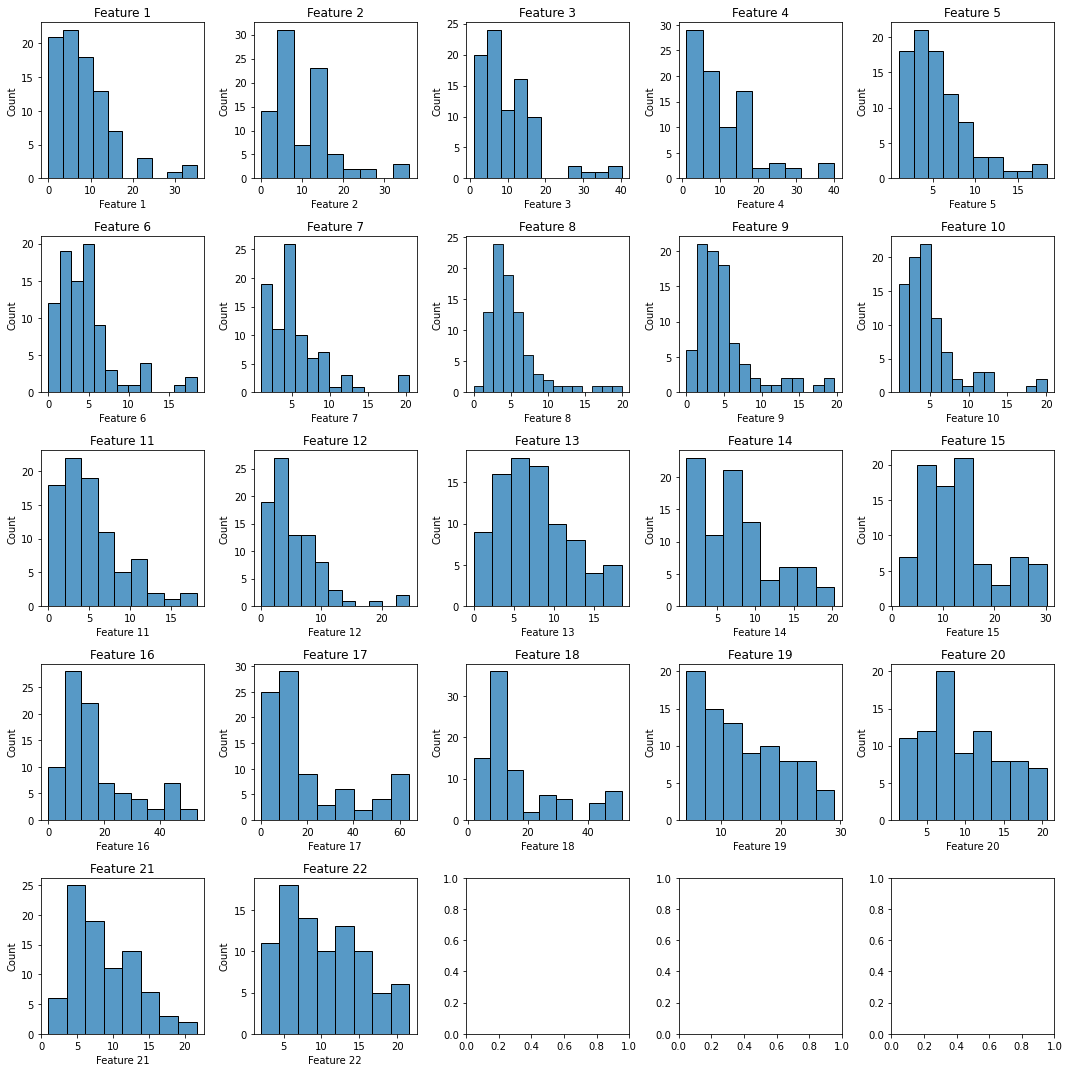

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

for i in range(5):
    for j in range(5):
        if i == 0:
            sns.histplot(ax=ax[i, j], data=X[f"Feature {i + j + 1}"])
            ax[i, j].set_title(f"Feature {i + j + 1}")
        if i == 1:
            sns.histplot(ax=ax[i, j], data=X[f"Feature {i + j + 5}"])
            ax[i, j].set_title(f"Feature {i + j + 5}")
        if i == 2:
            sns.histplot(ax=ax[i, j], data=X[f"Feature {i + j + 9}"])
            ax[i, j].set_title(f"Feature {i + j + 9}")
        if i == 3:
            sns.histplot(ax=ax[i, j], data=X[f"Feature {i + j + 13}"])
            ax[i, j].set_title(f"Feature {i + j + 13}")
        if i == 4:
            if j <= 1:
                sns.histplot(ax=ax[i, j], data=X[f"Feature {i + j + 17}"])
                ax[i, j].set_title(f"Feature {i + j + 17}")

plt.tight_layout()
plt.show()

## EDA Step 4. Boxplot
- It shows the distributions for each feature
- It shows the features has many outliers, but I decided to convert the outliers to mean values instead of removing them due to the dataset is very small 

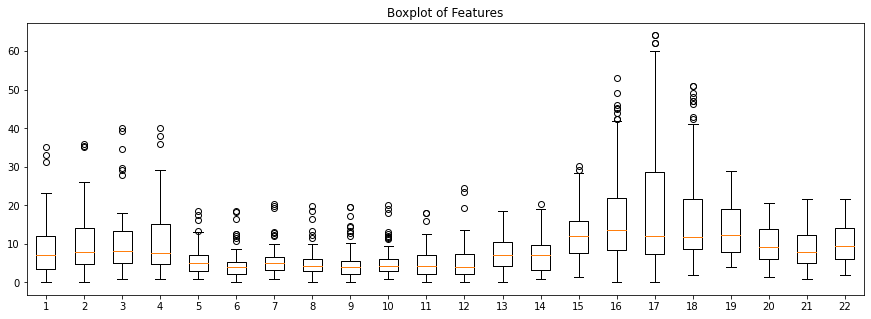

In [ ]:
plt.figure(figsize=(15, 5))
plt.boxplot(X)
plt.title("Boxplot of Features")
plt.show()

## EDA Step 5. Heatmap
- It shows the correlations between features
- It shows there are a lot of highly correlated features, but I checked the f1-score with remaining all the features because I do not have any information about the features
- The f1-score is enough high in validation and testing step, so I decided to do not remove or combine the highly correlated features

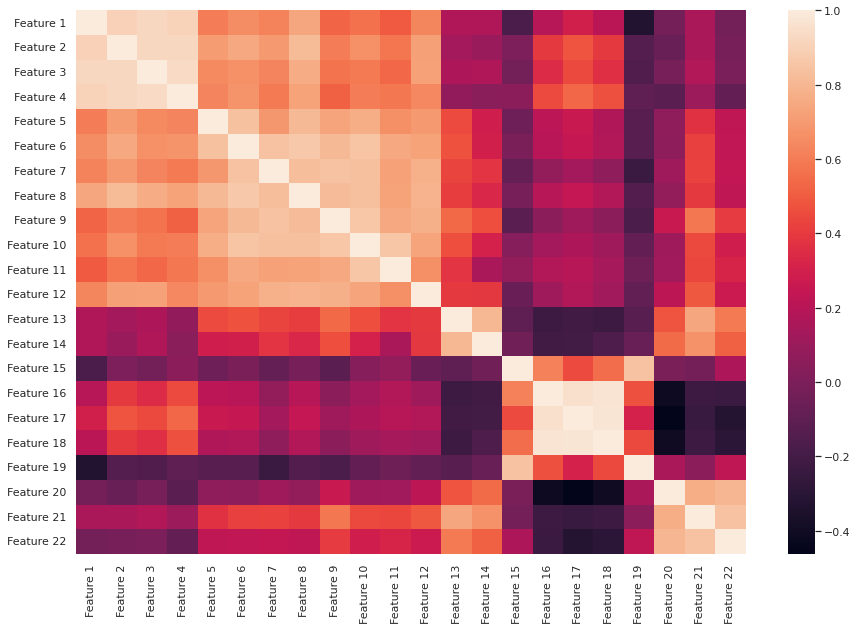

In [ ]:
sns.set(rc={"figure.figsize": (15, 10)})
sns.heatmap(X.corr())
plt.show()

# TRAINING
- It finds the optimal hyper parameters and covariances with given the training dataset path

Alpha:0.00 -- Beta:0.00 -- Accuracy:0.73 -- Recall:0.69 -- Precision:0.80 -- F1-Score:0.69
Alpha:0.00 -- Beta:0.10 -- Accuracy:0.87 -- Recall:0.86 -- Precision:0.87 -- F1-Score:0.84
Alpha:0.00 -- Beta:0.20 -- Accuracy:0.88 -- Recall:0.87 -- Precision:0.88 -- F1-Score:0.86
Alpha:0.00 -- Beta:0.30 -- Accuracy:0.88 -- Recall:0.87 -- Precision:0.88 -- F1-Score:0.86
Alpha:0.00 -- Beta:0.40 -- Accuracy:0.91 -- Recall:0.90 -- Precision:0.93 -- F1-Score:0.89
Alpha:0.00 -- Beta:0.50 -- Accuracy:0.94 -- Recall:0.92 -- Precision:0.95 -- F1-Score:0.92
Alpha:0.00 -- Beta:0.60 -- Accuracy:0.94 -- Recall:0.92 -- Precision:0.95 -- F1-Score:0.92
Alpha:0.00 -- Beta:0.70 -- Accuracy:0.96 -- Recall:0.93 -- Precision:0.95 -- F1-Score:0.93
Alpha:0.00 -- Beta:0.80 -- Accuracy:0.93 -- Recall:0.91 -- Precision:0.93 -- F1-Score:0.91
Alpha:0.00 -- Beta:0.90 -- Accuracy:0.94 -- Recall:0.93 -- Precision:0.95 -- F1-Score:0.93
Alpha:0.00 -- Beta:1.00 -- Accuracy:0.94 -- Recall:0.93 -- Precision:0.95 -- F1-Score:0.93

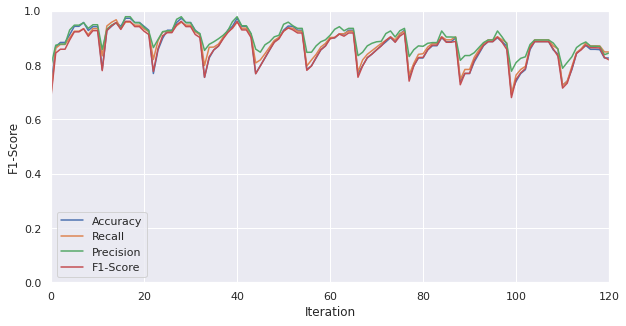

Optimal alpha:0.10 -- Optimal beta:0.50 -- Best f1-score:0.96




In [ ]:
train_data_path = "./facial_expression_train_dataset.csv"
mode = SelectMode("Train")
trained_model = mode.train(train_data_path)

# ===============
# TEST EVALUATION
# ===============
# ** PLEASE INPUT THE PATH OF TEST DATASET AND CHECK THE RESULT **

In [ ]:
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓ TEST DATASET PATH ↓↓↓↓↓↓↓↓↓↓↓↓↓↓
# ↓↓↓↓↓↓↓↓↓↓↓↓↓↓ TEST DATASET PATH ↓↓↓↓↓↓↓↓↓↓↓↓↓↓
test_data_path = "./test_set.csv"
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑ TEST DATASET PATH ↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑ TEST DATASET PATH ↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 



pre = Preprocessing()
X_test, y_test = pre.load_data(test_data_path)
trained_scaler = pre.load_scaler()
mode = SelectMode("Test")
y_test_list, pred_list, test_result = mode.test_evaluation(X_test, y_test, trained_scaler)
print(f"y_test: {y_test_list}")
print(f"pred_list: {pred_list}")
print(f"F1-Score: {test_result:.2f}")

y_test: [1, 1, 1, 3, 1, 3, 1, 3, 1, 2, 2, 3, 2, 2, 3, 2, 2, 3]
pred_list: [1, 1, 1, 3, 1, 3, 1, 3, 1, 2, 2, 3, 2, 2, 3, 2, 2, 3]
F1-Score: 1.00
